# [T275672](https://phabricator.wikimedia.org/T275672) Data QA for mediawiki_client_session_tick



In this task we will be performing dataQA checks on the event table (aka raw table) [event.mediawiki_client_session_tick](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/session_tick/2.0.0.yaml) and verify if the Instrumentation 
is working correctly.  

Currently the instrumentation is deployed on [all](https://wikitech.wikimedia.org/wiki/Deployments/Train) wikis. _Please note that the raw table is sampled at a rate of 1/10_

**Observations from Session Length data-QA of Raw table** 
 
- we checked Session Length duration - by day, wiki and browser
- Session Length (sampled at 1/100) per day increases from Feb 23 since the instrument was deployed to Group 2 wikis 
- On Mar 09, the sampling rate was increased to 1/10, which contributed to another sharp rise in the overall session length.
- English wikipedia has the longest session length compared to all other  projects.
- Time spent on enwiki is almost 50% greater than all other wikis combined.
- Chrome and Chrome mobile browser has the longest session length amongst all browsers, followed closely by Mobile Safari.
- Count of Tick 0s is greater than all other ticks in the raw table which is ideal.
- There aren't any records where tick value is null
- Only mediawiki.client.session_tick stream data are in the schema


In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter as mpl
import numpy as np
import pandas as pd
from tabulate import tabulate
from wmfdata import charting, hive, mariadb
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import df_to_remarkup, pct_str
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%d M" % round(x/1000000)
@ticker.FuncFormatter
def thousand_formatter(x, pos):
    return "%d K" % round(x/1000)

## 1. Session Length duration 
Look at the sessions lengths in the raw table.
We will do this by Counting all the non-zero Ticks from event table (since one tick is sent every 1 minute)   
#### 1.1 Session Length duration by day

In [2]:
# Session Length per day from raw table

sl_day_mwsessiontick = hive.run("""
SELECT
  date_format(meta.dt, "yyyy-MM-dd"),
  COUNT(1) AS mwst_sessionlength
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND ((month=2 AND day>=20) OR (month=3))
  --Since Session tick was deployed to Group 2 wikis on Feb 23, 2021
  
  AND tick <>0 
  --removing tick 0s since we are counting rows of all the ticks received
  
  AND is_wmf_domain
  --adding filter for removing non-wmf events
  
GROUP BY date_format(meta.dt, "yyyy-MM-dd")
""")

In [3]:
sl_day_mwsessiontick=sl_day_mwsessiontick.rename(columns={"_c0": "date"})
sl_day_mwsessiontick.sort_values(by=['date'], inplace=True, ascending=True)

In [4]:
sl_day_mwsessiontick1=sl_day_mwsessiontick.reset_index()

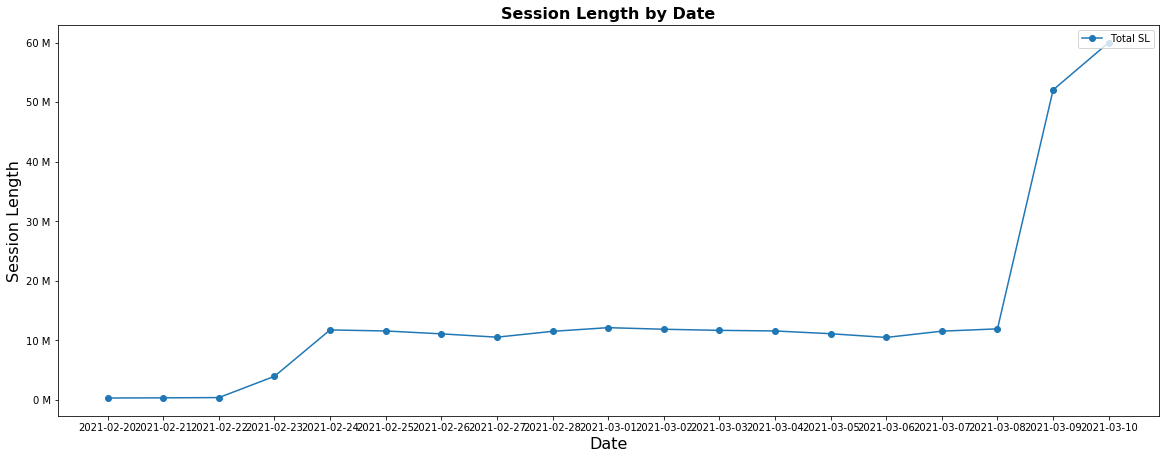

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1, w_pad=0.5, h_pad=6)
ax.set_title('Session Length by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Session Length',  fontsize = 16)
ax.plot(sl_day_mwsessiontick1['date'], 
        sl_day_mwsessiontick1['mwst_sessionlength'], 'o-', label='Total SL')


ax.yaxis.set_major_formatter(million_formatter)
#ax.set_xlim(1,10)
#ax.set_ylim(2000000,20000000)
ax.legend(loc='upper right')

plt.show()

In [6]:
sl_day_mwsessiontick['mwst_sessionlength'] = sl_day_mwsessiontick.apply(
    lambda x: "{:,}".format(x['mwst_sessionlength']),axis=1)                         

On Feb 23, the instrument was deployed to Group 2 wikis and hence the rise in Session Length per day. The data was sampled at 1/100.    
On Mar 09, the sampling rate was increased to 1/10.

In [7]:
sl_day_mwsessiontick

,date,mwst_sessionlength
9,2021-02-20,"295,641"
10,2021-02-21,"329,513"
11,2021-02-22,"369,406"
12,2021-02-23,"3,941,994"
13,2021-02-24,"11,734,000"
14,2021-02-25,"11,557,614"
15,2021-02-26,"11,074,375"
16,2021-02-27,"10,515,934"
17,2021-02-28,"11,497,425"
0,2021-03-01,"12,113,599"


#### 1.2 Session Length duration by wiki

In [8]:
# Session Length per wiki from raw table

sl_wiki_mwsessiontick = hive.run("""
SELECT
  regexp_replace(meta.domain, '(www\\.|\\.org|^m\\.|\\.m)', '') AS wiki,
  COUNT(1) AS mwst_sessionlength
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND ((month=2 AND day>=20) OR (month=3))
  --Since Session tick was deployed to Group 2 wikis on Feb 23, 2021
  
  AND tick <>0 
  --removing tick 0s since we are counting rows of all the ticks received
  
  AND is_wmf_domain
  --adding filter for removing non-wmf events
  
GROUP BY regexp_replace(meta.domain, '(www\\.|\\.org|^m\\.|\\.m)', '')
ORDER BY mwst_sessionlength DESC
LIMIT 100
""")

In [23]:
sl_wiki_mwsessiontick_top10=sl_wiki_mwsessiontick.head(10)

In [24]:
sl_wiki_mwsessiontick_top10

,wiki,mwst_sessionlength
0,en.wikipedia,119883616
1,es.wikipedia,22620652
2,ja.wikipedia,16757604
3,de.wikipedia,15869499
4,ru.wikipedia,14066546
5,fr.wikipedia,12653722
6,it.wikipedia,9257316
7,zh.wikipedia,5745533
8,pl.wikipedia,5133303
9,pt.wikipedia,4982088


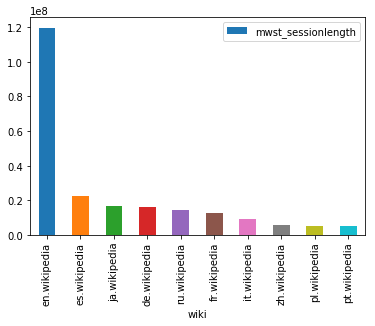

In [25]:
ax=sl_wiki_mwsessiontick_top10.plot.bar(x='wiki',y='mwst_sessionlength')

English wikipedia has the longest session length compared to all other wiki projects.   
Time spent on enwiki is almost 50% greater than all other wikis combined.  

In [11]:
sl_wiki_mwsessiontick1 = pd.DataFrame(sl_wiki_mwsessiontick,  columns = ['wiki', 'mwst_sessionlength']) 

In [12]:
sl_wiki_mwsessiontick1['percent'] = (sl_wiki_mwsessiontick1['mwst_sessionlength'] / 
                  sl_wiki_mwsessiontick1['mwst_sessionlength'].sum()) * 100
  

##### Session Length wiki proportion

In [13]:
sl_wiki_mwsessiontick1.head()

,wiki,mwst_sessionlength,percent
0,en.wikipedia,119883616,45.325309
1,es.wikipedia,22620652,8.552362
2,ja.wikipedia,16757604,6.335675
3,de.wikipedia,15869499,5.999902
4,ru.wikipedia,14066546,5.318246


#### 1.3 Session Length duration by Browser

In [14]:
# Session Length by browser from raw table

sl_browser_mwsessiontick = hive.run("""
SELECT
  user_agent_map['browser_family'] AS browser,
  COUNT(1) AS mwst_sessionlength
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND ((month=2 AND day>=20) OR (month=3))
  --Since Session tick was deployed to Group 2 wikis on Feb 23, 2021
  
  AND tick <>0 
  --removing tick 0s since we are counting rows of all the ticks received
  
  AND is_wmf_domain
  --adding filter for removing non-wmf events
  
GROUP BY   user_agent_map['browser_family']
ORDER BY mwst_sessionlength DESC
LIMIT 100
""")

In [16]:
sl_browser_mwsessiontick1 = pd.DataFrame(sl_browser_mwsessiontick,  
                                         columns = ['browser', 'mwst_sessionlength']) 

In [17]:
sl_browser_mwsessiontick1['percent'] = (sl_browser_mwsessiontick1['mwst_sessionlength'] / 
                  sl_browser_mwsessiontick1['mwst_sessionlength'].sum()) * 100
  

In [18]:
sl_browser_mwsessiontick2=sl_browser_mwsessiontick1.head(10)

Chrome and Chrome mobile browser has the longest session length amongst all other browsers, followed closely by Mobile Safari. 

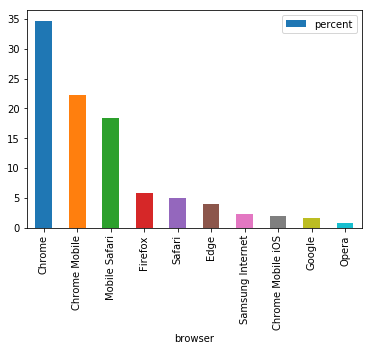

In [19]:
ax=sl_browser_mwsessiontick2.plot.bar(x='browser',y='percent')

##### Session Length Browser proportion

In [22]:
sl_browser_mwsessiontick2

,browser,mwst_sessionlength,percent
0,Chrome,92093558,34.682562
1,Chrome Mobile,59136005,22.270702
2,Mobile Safari,48905899,18.418030
3,Firefox,15353692,5.782222
4,Safari,13461415,5.069588
5,Edge,10643252,4.008263
6,Samsung Internet,6064756,2.283996
7,Chrome Mobile iOS,5319661,2.003392
8,Google,4368430,1.645157
9,Opera,2199854,0.828468


### 2. Tick checks on raw table

In [20]:
# Count Ticks from raw table

mwsessiontick = hive.run("""
SELECT
  tick,
  COUNT(1) AS total_ticks
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND ((month=2 AND day>=20) OR (month=3))
  --Since Session tick was deployed to Group 2 wikis on Feb 23, 2021
  
  AND is_wmf_domain
GROUP BY tick HAVING tick<20
""")

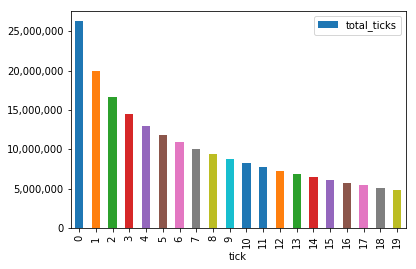

In [27]:
ax = mwsessiontick.plot(x='tick', y='total_ticks', kind='bar')
ax.yaxis.set_major_formatter(mpl('{x:,.0f}'))
plt.show()

Count of Tick 0s is greater than all other ticks in the raw table which is ideal.

In [28]:
# Count null Ticks from raw table

mwsessiontick_check = hive.run("""
SELECT
  regexp_replace(meta.domain, '(www\\.|\\.org|^m\\.|\\.m)', '') AS wiki,
  COUNT(1) AS total_null_ticks
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND ((month=2 AND day>=20) OR (month=3))
  --Since Session tick was deployed to Group 2 wikis on Feb 23, 2021
  
  AND is_wmf_domain

--Checking for tick values that are null
  AND tick IS NULL 
  
GROUP BY regexp_replace(meta.domain, '(www\\.|\\.org|^m\\.|\\.m)', '') 
""")

In [29]:
mwsessiontick_check

,wiki,total_null_ticks


There aren't records where tick value is null

In [30]:
# Max value from raw table

mwst_max = hive.run("""
SELECT year, max(tick) AS max_mwst_sl
FROM event.mediawiki_client_session_tick
WHERE year = 2021 
  AND ((month=2 AND day>=20) OR (month=3))
  --Since Session tick was deployed to Group 2 wikis on Feb 23, 2021
  AND is_wmf_domain
  --adding filter for removing non-wmf events
GROUP BY year
""")
mwst_max

,year,max_mwst_sl
0,2021,21461


In [31]:
# Stream from raw table

sl_stream_mwsessiontick = hive.run("""
SELECT
  date_format(meta.dt, "yyyy-MM-dd"),
  COUNT(1) AS mwst_sessionlength
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND ((month=2 AND day>=20) OR (month=3))
  --Since Session tick was deployed to Group 2 wikis on Feb 23, 2021
  
  AND tick <>0 
  --removing tick 0s since we are counting rows of all the ticks received
  
  AND is_wmf_domain
  --adding filter for removing non-wmf events
  
  AND meta.stream <> "mediawiki.client.session_tick"
  --Checking if data from streams other than session_tick have made it to the schema

GROUP BY date_format(meta.dt, "yyyy-MM-dd")
""")    

In [32]:
sl_stream_mwsessiontick

,_c0,mwst_sessionlength


Only mediawiki.client.session_tick stream data are in the schema